In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from loguru import logger

In [13]:

def sigmoid(x: float):
    # Logistic regression function (Sigmoid)
    output = 1 / (1 + np.exp(-x))
    return output


def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex/ex.sum()

def read_csv(path: str) -> pd.DataFrame:
    file = pd.read_csv(path)
    return file



def feature_rep(train_set, val_set, test_set):
    # Create feature representations for data
    word2vec = {}
    word_set = {}
    word_all = []
    idx = 0
    # logger.debug(train_set)
    for dataset in (train_set, val_set, test_set):
        for text in dataset.text:
            words = text.split()
            for word in words:
                if word not in word2vec:
                    word_all.append(word)
                    word2vec[word] = idx
                    idx += 1
        word_set = set(word_all)
        # logger.debug(idx)
    # logger.info(len(word2vec))
    # logger.info(len(word_set))
        # print(text)
        # break
    return word2vec


def text_features(dataset, embedding):
    text_features = []
    for text in dataset.text:
        features = [0] * len(embedding)
        words = text.split()
        for word in words:
            features[embedding[word]] = 1
        text_features.append(features)
    # logger.info(len(text_features[0]))
    # logger.info(len(text_features))
    return text_features


def data_cleaning(dataset: pd.DataFrame) -> None:
    '''
        Clean the duplicated entries
    '''
    dataset = dataset.sort_values("id")
    dataset_dup = dataset.duplicated(subset=["id"])
    index = np.where(dataset_dup==True)
    dataset = dataset.drop(index[0])
    return dataset


def data_loading(epoch, num_epochs):
    # Load raw dataset
    TRAIN_PATH = "./train.csv"
    TEST_PATH = "./test.csv"
    train_set = read_csv(TRAIN_PATH)
    test_set = read_csv(TEST_PATH)
    
    # data cleaning
    train_set = data_cleaning(train_set)
    test_set = data_cleaning(test_set)
    # logger.info(f"After data cleaning, len(train_set) is {len(train_set)}, len(test_set) is {len(test_set)}")

    # Cross validation
    df_shuffle = train_set.sample(frac=1)
    # logger.info(len(df_shuffle))
    df_size = len(df_shuffle)
    idx_split_left = df_size//num_epochs * (epoch)
    idx_split_right = df_size//num_epochs * (epoch+1)
    train_set = pd.concat([df_shuffle.iloc[:idx_split_left], df_shuffle.iloc[idx_split_right:]])
    val_set = df_shuffle.iloc[idx_split_left:idx_split_right]
    return train_set, val_set, test_set

def pre_processing(train_set: pd.DataFrame, val_set: pd.DataFrame, test_set: pd.DataFrame):
    
    embedding = feature_rep(train_set, val_set, test_set)
    # Create trianing and testing inputs
    text_features_train = text_features(train_set, embedding)
    text_features_val = text_features(val_set, embedding)
    text_features_test = text_features(test_set, embedding)
    
    # Create labels
    emotions_train = [_ for _ in train_set.emotions]
    emotions_val = [_ for _ in val_set.emotions]

    emotion_set = set(emotions_train)

    emotion2int = {emotion: i for i, emotion in enumerate(emotion_set)}
    int2emotion = {i: emotion for i, emotion in enumerate(emotion_set)}
    
    emotions_train = [emotion2int[emotion] for emotion in emotions_train]
    emotions_val = [emotion2int[emotion] for emotion in emotions_val]
    train_targets = np.zeros((len(emotions_train), len(emotion_set)))
    val_targets = np.zeros((len(emotions_val), len(emotion_set)))
    for i, emotion in enumerate(emotions_train):
        train_targets[i, emotion] = 1
    for i, emotion in enumerate(emotions_val):
        val_targets[i, emotion] = 1

    return embedding, text_features_train, text_features_val, text_features_test,\
        emotion_set, train_targets, val_targets, emotion2int, int2emotion


def post_processing(test_set, pred_emotions):
    output = test_set.copy()
    output['emotions'] = pred_emotions
    output.to_csv("./test_lr.csv")
    return output


In [86]:
class NN:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]
        self.biases = [np.zeros(layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]
    
    def layers(self):
        return [(self.weights[i], self.biases[i]) for i in range(len(self.layer_sizes)-1)]
    
    def forward(self, X):

        activations = [X]
        for i in range(len(self.layer_sizes)-1):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activation = np.maximum(0, z) # ReLU activation
            activations.append(activation)
        return activations
    
    def backward(self, X, y):
        activations = self.forward(X)
        d_activations = [2*(activations[-1] - y)]
        d_weights = []
        d_biases = []
        for i in range(len(self.layer_sizes)-2, -1, -1):
            d_activation = d_activations[0]
            z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            d_z = d_activation * (z > 0).astype(float) # ReLU derivative
            d_weight = np.dot(activations[i].T, d_z)
            d_bias = np.sum(d_z, axis=0)
            d_activations.insert(0, np.dot(d_z, self.weights[i].T))
            d_weights.insert(0, d_weight)
            d_biases.insert(0, d_bias)
        return d_weights, d_biases
    
    def train(self, X, y, learning_rate=0.1, num_epochs=50):
        for epoch in range(num_epochs):
            # logger.debug(X)
            # logger.debug(y)
            d_weights, d_biases = self.backward(X, y)
            for i in range(len(self.layer_sizes)-1):
                self.weights[i] -= learning_rate * d_weights[i]
                self.biases[i] -= learning_rate * d_biases[i]
    
    def predict(self, X):
        activations = self.forward(X)
        return activations[-1]


In [4]:
def read_csv(path: str) -> pd.DataFrame:
    file = pd.read_csv(path)
    return file

TRAIN_SET = pd.DataFrame(read_csv("./train.csv"))
TEST_SET = pd.DataFrame(read_csv("./test.csv"))
TRAIN_SET.head()

,id,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [5]:
dataset_train = TRAIN_SET
dataset_test = TEST_SET

In [6]:
texts_train = np.array([dataset_train["text"]])
emotions_train = np.array([dataset_train["emotions"]])

texts_test = np.array([dataset_test["text"]])

In [7]:
emotions_train

array([['sadness', 'sadness', 'joy', ..., 'sadness', 'surprise',
        'sadness']], dtype=object)

In [54]:
labels = np.unique(emotions_train)
num_labels = len(labels)

one_hot = np.zeros((num_labels, num_labels), np.int8)
np.fill_diagonal(one_hot, 1)

label_dict = dict(zip(labels, one_hot))
# logger.debug(label_dict)

gt_one_hot = np.array([label_dict[label] for label in emotions_train[0]])

In [48]:
texts_train.shape

(1, 1200)

In [49]:
folds = 5
fold = 1

In [74]:
train_set, val_set, test_set = data_loading(fold, folds)
embedding, text_features_train, text_features_val, _,\
        emotion_set, train_targets, val_targets, _, _ = pre_processing(train_set, val_set, test_set)

In [91]:
layer_sizes = [len(text_features_train[0]), 128, 64, len(emotion_set)]
nn = NN(layer_sizes)
# logger.debug(text_features_train[0].shape)
# logger.debug(train_targets.shape)
nn.train(np.array(text_features_train), train_targets, 100)



In [92]:
emotions_pred = nn.predict(text_features_val)

emotions_pred_lables = np.array([labels[_] for _ in np.argmax(emotions_pred, axis=1)])


In [93]:
np.array(emotions_pred)

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [236]:
class NeuralNetwork:
    # Reference: https://pylessons.com/Neural-network-single-layer-part3
    # Reference: https://towardsai.net/p/machine-learning/nothing-but-numpy-understanding-creating-neural-networks-with-computational-graphs-from-scratch-6299901091b0
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        # logger.debug(f"W1: {self.W1.shape}")
        self.b1 = np.zeros((1, hidden_size))
        # logger.debug(f"b1: {self.b1.shape}")
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        # logger.debug(f"W2: {self.W2.shape}")
        self.b2 = np.zeros((1, output_size))
        # logger.debug(f"b2: {self.b2.shape}")
        self.scores = []
    def forward(self, X):
        # logger.debug(X.shape)
        # logger.debug(self.W1.shape)
        self.z1 = np.dot(X, self.W1) + self.b1
        # logger.debug(f"z1: {self.z1.shape}")
        # self.a1 = np.tanh(self.z1)
        # Use ReLU instead
        self.a1 = np.maximum(0, self.z1)
        # logger.debug(self.W2.shape)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        exp_scores = np.exp(self.z2 - np.max(self.z2))
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.probs
    
        
    def backward(self, X, y, y_hat, learning_rate):
        # logger.debug(f"X.shape={X.shape}, y.shape={y.shape}, y_hat.shape={y_hat.shape}")
        delta2 = y_hat
        delta2[range(len(X)), np.argmax(y, axis=1)] -= 1
        # logger.debug(self.W2.shape)
        # logger.debug(self.z1.shape)
        delta1 = delta2.dot(self.W2.T) * (1 - np.power(np.tanh(self.z1), 2))
        
        dW2 = np.dot(self.a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)

        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, X, y, val_targets, text_features_val, num_epochs, learning_rate):
        for epoch in range(num_epochs):
            # forward pass
            y_hat = self.forward(X)
            # calculate the loss
            correct_logprobs = -np.log(y_hat[range(len(X)), np.argmax(y, axis=1)]+1e-12)
            data_loss = np.sum(correct_logprobs) / len(X)
            # print the loss every 100 epochs
            

                # self.scores.append(score)
            # backward pass
            # logger.debug(X.shape)
            # logger.debug(y.shape)
            self.backward(X, y, y_hat, learning_rate)
            if epoch % 100 == 0:
                pred_val = self.predict(text_features_val)
                score = np.mean(np.argmax(pred_val, axis=1) == np.argmax(val_targets, axis=1))
                self.scores.append(score)
                logger.info(f"Epoch: {epoch}, loss: {data_loss}, accuracy: {score * 100:.2f}%.")

            # eval

            
            
    def predict(self, X):
        # forward pass
        y_hat = self.forward(X)
        # return the index with highest probability
        # logger.debug(y_hat.shape)
        return y_hat



    def get_scores(self):
        return self.scores

In [209]:
text_features_train.shape

(956, 4892)

In [255]:
TRAIN_PATH = "./train.csv"
TEST_PATH = "./test.csv"
train_set = read_csv(TRAIN_PATH)
test_set = read_csv(TEST_PATH)
val_set = read_csv(TRAIN_PATH)
train_set = data_cleaning(train_set)
val_set = data_cleaning(val_set)
test_set = data_cleaning(test_set)
embedding, _, _, text_features_test,\
        emotion_set, _, _, emotion2int, int2emotion = pre_processing(train_set, val_set, test_set)

folds = 5
scores = []
best_score = 0
for fold in range(folds):
    train_set, val_set, test_set = data_loading(fold, folds)
    _, text_features_train, text_features_val, _,\
            _, train_targets, val_targets, _, _ = pre_processing(train_set, val_set, test_set)
    weights = np.zeros((len(embedding), len(emotion_set)))
    if fold == 0:
        logger.info(f"Input size = {np.array(text_features_train).shape}")
    text_features_train = np.array(text_features_train)
    train_targets = np.array(train_targets)
    text_features_val = np.array(text_features_val)
    val_targets = np.array(val_targets)
    X = np.array(text_features_train)
    y = np.array(train_targets)
    # create a neural network with 100 hidden units
    nn = NeuralNetwork(len(text_features_train[0]), 120, len(emotion_set))\

    # train the neural network
    num_epochs = 800
    lr = 0.001
    nn.train(X, y, val_targets, text_features_val, num_epochs=num_epochs, learning_rate=lr)

    scores_fold = nn.get_scores()
    scores.append(scores_fold)
    if scores_fold[-1] > best_score:
        best_nn = nn
        best_score = scores_fold[-1]
    logger.info(f"Best Accuracy = {best_score * 100:.2f}%")
    # break
for score in scores:
    plt.plot(np.arange(len(score)), score)
plt.title(f"NN: {folds}-fold Cross Validation, lr={lr}, epochs={num_epochs}, acc={best_score}")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
plt.savefig(f"NN_highestAcc={best_score}_{folds}-fold Cross Validation_lr={lr}_epochs={num_epochs}.png")


2023-03-02 00:16:48.162 | INFO     | __main__:<cell line: 15>:21 - Input size = (956, 4892)
2023-03-02 00:16:48.661 | INFO     | __main__:train:66 - Epoch: 0, loss: 1.7913375730882561, accuracy: 39.75%.
2023-03-02 00:16:55.470 | INFO     | __main__:train:66 - Epoch: 100, loss: 1.0893748780437915, accuracy: 35.98%.


KeyboardInterrupt: 

In [228]:
scores = nn.get_scores()
scores

[0.32217573221757323,
 0.34309623430962344,
 0.4895397489539749,
 0.4560669456066946,
 0.4769874476987448,
 0.4769874476987448,
 0.4895397489539749,
 0.48535564853556484,
 0.48535564853556484,
 0.4811715481171548,
 0.4895397489539749,
 0.4895397489539749,
 0.49372384937238495,
 0.497907949790795,
 0.497907949790795,
 0.497907949790795,
 0.497907949790795,
 0.497907949790795,
 0.497907949790795,
 0.497907949790795]

Text(0, 0.5, 'Validation Accuracy')

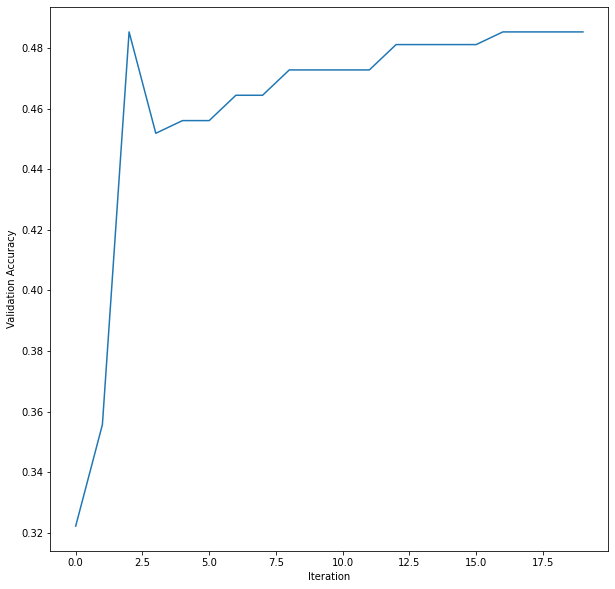

In [214]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(len(scores)), scores)
# plt.title(f"{folds}-fold Cross Validation, lr={lr}, epochs={num_epochs}, highest acc={nn.scores}")
plt.xlabel("Iteration")
plt.ylabel("Validation Accuracy")
# plt.savefig(f"LR_highestAcc={scores}_{folds}-fold Cross Validation_lr={learning_rate}_lambda={reg_lambda}_iteration={num_iters}.png")


2023-03-02 00:17:45.407 | INFO     | __main__:<cell line: 15>:24 - Input size = (956, 4892)
2023-03-02 00:17:45.871 | INFO     | __main__:train:66 - Epoch: 0, loss: 1.791159860452829, accuracy: 37.66%.
2023-03-02 00:17:51.766 | INFO     | __main__:train:66 - Epoch: 100, loss: 1.1329479239856082, accuracy: 35.98%.
2023-03-02 00:17:57.882 | INFO     | __main__:train:66 - Epoch: 200, loss: 0.21475195208183412, accuracy: 51.05%.
2023-03-02 00:18:03.252 | INFO     | __main__:train:66 - Epoch: 300, loss: 0.0411970457102648, accuracy: 50.63%.
2023-03-02 00:18:09.228 | INFO     | __main__:train:66 - Epoch: 400, loss: 0.019359216192968952, accuracy: 50.21%.
2023-03-02 00:18:14.613 | INFO     | __main__:<cell line: 15>:44 - Best Accuracy = 50.21%
2023-03-02 00:18:15.214 | INFO     | __main__:train:66 - Epoch: 0, loss: 1.7912421789124608, accuracy: 36.40%.
2023-03-02 00:18:20.274 | INFO     | __main__:train:66 - Epoch: 100, loss: 1.1250326163940652, accuracy: 39.75%.
2023-03-02 00:18:25.346 | INF

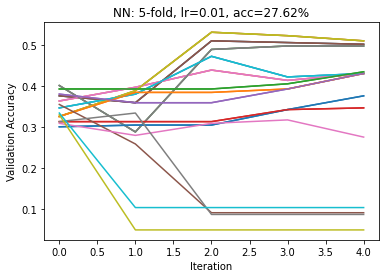

In [257]:
TRAIN_PATH = "./train.csv"
TEST_PATH = "./test.csv"
train_set = read_csv(TRAIN_PATH)
test_set = read_csv(TEST_PATH)
val_set = read_csv(TRAIN_PATH)
train_set = data_cleaning(train_set)
val_set = data_cleaning(val_set)
test_set = data_cleaning(test_set)
embedding, _, _, text_features_test,\
        emotion_set, _, _, emotion2int, int2emotion = pre_processing(train_set, val_set, test_set)

folds = 5
scores = []
lr_list = [0.001, 0.0001, 0.01]
best_scores = []
for lr in lr_list:
        best_score = 0
        
        for fold in range(folds):
                train_set, val_set, test_set = data_loading(fold, folds)
                _, text_features_train, text_features_val, _,\
                        _, train_targets, val_targets, _, _ = pre_processing(train_set, val_set, test_set)
                weights = np.zeros((len(embedding), len(emotion_set)))
                if fold == 0:
                        logger.info(f"Input size = {np.array(text_features_train).shape}")
                text_features_train = np.array(text_features_train)
                train_targets = np.array(train_targets)
                text_features_val = np.array(text_features_val)
                val_targets = np.array(val_targets)
                X = np.array(text_features_train)
                y = np.array(train_targets)
                # create a neural network with 100 hidden units
                nn = NeuralNetwork(len(text_features_train[0]), 120, len(emotion_set))
                # train the neural network
                num_epochs = 500

                
                nn.train(X, y, val_targets, text_features_val, num_epochs=num_epochs, learning_rate=lr)

                scores_fold = nn.get_scores()
                scores.append(scores_fold)
                if scores_fold[-1] > best_score:
                        best_nn = nn
                        best_score = scores_fold[-1]
                logger.info(f"Best Accuracy = {best_score * 100:.2f}%")
        best_scores.append(best_score)
                # break
        for score in scores:
                plt.plot(np.arange(len(score)), score)
        plt.title(f"NN: {folds}-fold, lr={lr}, acc={best_score * 100:.2f}%")
        plt.xlabel("Iteration")
        plt.ylabel("Validation Accuracy")
        plt.savefig(f"NN_highestAcc={best_score}_{folds}-fold Cross Validation_lr={lr}_epochs={num_epochs}.png")

In [260]:
best_scores

[0.27615062761506276]

ValueError: x and y must have same first dimension, but have shapes (3,) and (1,)

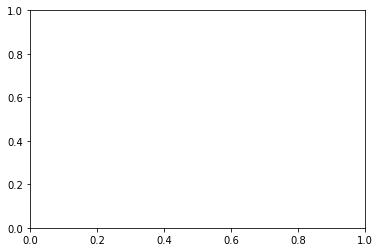

In [261]:
plt.plot(np.array(lr_list), best_scores)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("LR vs. Accuracy")
plt.savefig("NN_Acc_Curve.png")